# Description:

    A quick and dirty ordination of all OTUs



# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [7]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 68K
lrwxrwxrwx 1 bryan bryan  130 Nov 13 09:13 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Nov 13 09:13 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 7.4K Nov 10 06:58 NMDS_full_wunif.pdf
-rw-rw-r-- 1 bryan bryan 7.9K Nov  9 13:18 NMDS_plant_wunif.pdf
-rw-rw-r-- 1 bryan bryan 9.7K Sep 29 18:03 NMDS_DAPfacet.pdf
-rw-rw-r-- 1 bryan bryan 8.0K Aug 11 19:58 facet_NMDS_w-enz.pdf
-rw-rw-r-- 1 bryan bryan  22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [8]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [9]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


## Normalize samples and filter out taxa that are less than .1*length(x)

In [10]:
%%R 
# filtering/normalizing
physeq.p = prune_samples(sampleSums(physeq) >= 10, physeq)

PassFilter = 
filter_taxa(physeq, 
             function(x) sum(x > 3) > 3, TRUE) %>%
                 taxa_names()

physeq.snorm = transform_sample_counts(physeq.p, function(x) x/sum(x))

physeq.snorm = prune_taxa(PassFilter, physeq)  
    


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4986 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4986 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4986 tips and 4985 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [13]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1403636 
Run 1 stress 0.1587971 
Run 2 stress 0.1766024 
Run 3 stress 0.1879062 
Run 4 stress 0.1410926 
Run 5 stress 0.1879234 
Run 6 stress 0.1645693 
Run 7 stress 0.1712256 
Run 8 stress 0.227006 
Run 9 stress 0.1849843 
Run 10 stress 0.1668996 
Run 11 stress 0.1420153 
Run 12 stress 0.1666773 
Run 13 stress 0.1452825 
Run 14 stress 0.1417149 
Run 15 stress 0.1562967 
Run 16 stress 0.1739017 
Run 17 stress 0.1607674 
Run 18 stress 0.1461533 
Run 19 stress 0.1684215 
Run 20 stress 0.140351 
... New best solution
... procrustes: rmse 0.002300445  max resid 0.02664795 


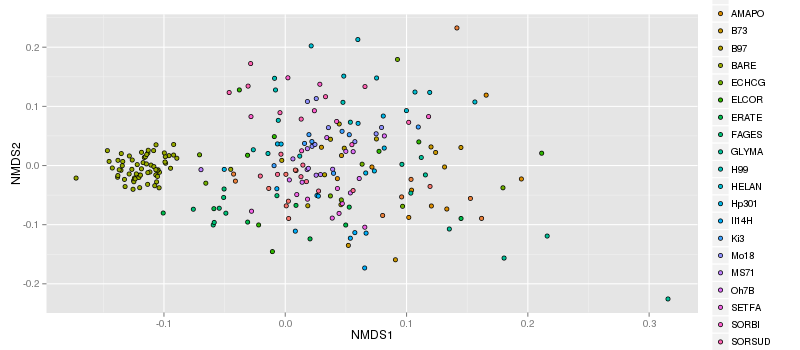

In [14]:
%%R -w 800 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

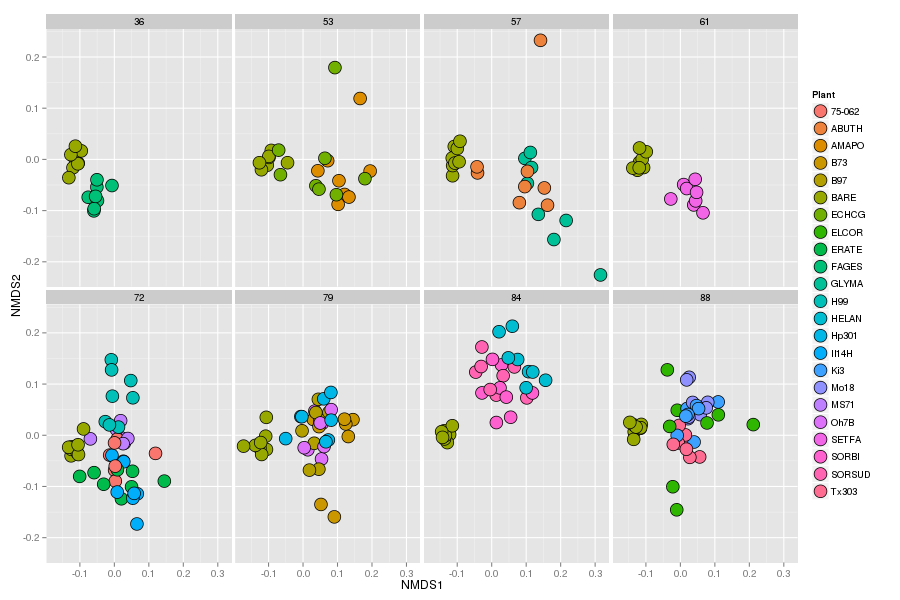

In [23]:
%%R -w 900 -h 600


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP, nrow = 2)

p1 %>% print
ggsave(filename = "NMDS_DAPfacet.pdf", plot = p1)

##Subset just bare soils to analyze change with time

In [23]:
%%R

bare = subset_samples(physeq.thresh, Plant == "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)


In [40]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(bare, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [41]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = wunif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1546811 
Run 1 stress 0.154686 
... procrustes: rmse 0.001843172  max resid 0.01021917 
Run 2 stress 0.1546812 
... procrustes: rmse 8.257062e-06  max resid 3.860869e-05 
*** Solution reached


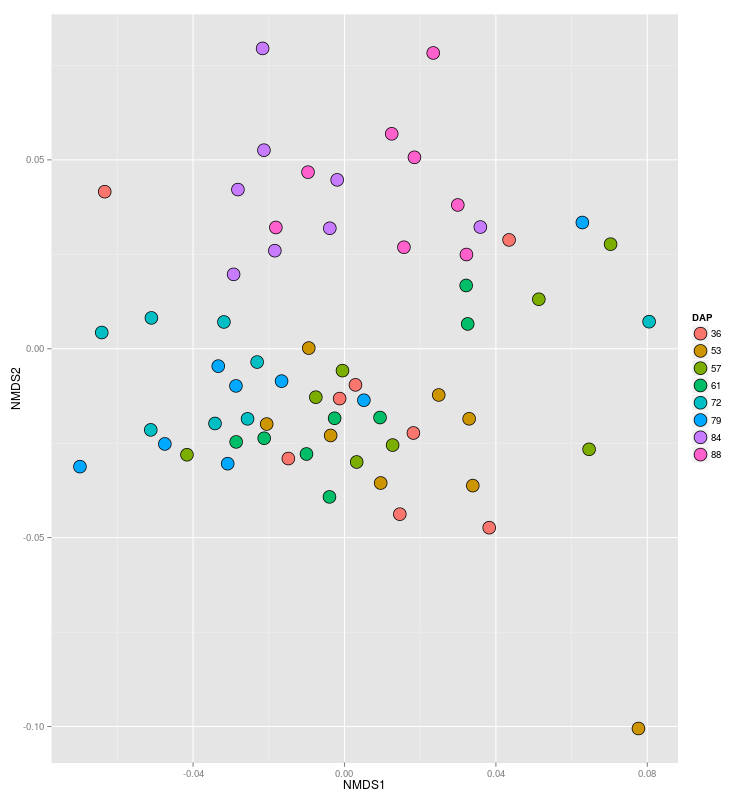

In [42]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), size = 6, pch=21) 

p1

In [45]:
%%R
df = as(sample_data(bare), "data.frame")
d = wunif.dist
bareadonis = adonis(d ~ DAP, df)
bareadonis


Call:
adonis(formula = d ~ DAP, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
DAP        7   0.09486 0.0135518  3.1129 0.28012  0.001 ***
Residuals 56   0.24379 0.0043534         0.71988           
Total     63   0.33865                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##Subset just plants to evaluate variation without bare soil

In [29]:
%%R

plant = subset_samples(physeq.thresh, Plant != "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)
plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11237 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11237 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11237 tips and 11236 internal nodes ]


In [46]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [31]:
%%R -w 800 -h 350


nmds = ordinate(plant, 
                method = "NMDS", 
               distance = wunif.dist)

p = plot_ordination(plant, nmds, justDF = TRUE)

Run 0 stress 0.1715634 
Run 1 stress 0.1952897 
Run 2 stress 0.2226994 
Run 3 stress 0.1866363 
Run 4 stress 0.1814163 
Run 5 stress 0.2000779 
Run 6 stress 0.1877139 
Run 7 stress 0.1746978 
Run 8 stress 0.1848458 
Run 9 stress 0.1816994 
Run 10 stress 0.1796017 
Run 11 stress 0.1898574 
Run 12 stress 0.1791418 
Run 13 stress 0.1865826 
Run 14 stress 0.1780833 
Run 15 stress 0.178548 
Run 16 stress 0.1880433 
Run 17 stress 0.4160363 
Run 18 stress 0.1851546 
Run 19 stress 0.1775369 
Run 20 stress 0.2333198 


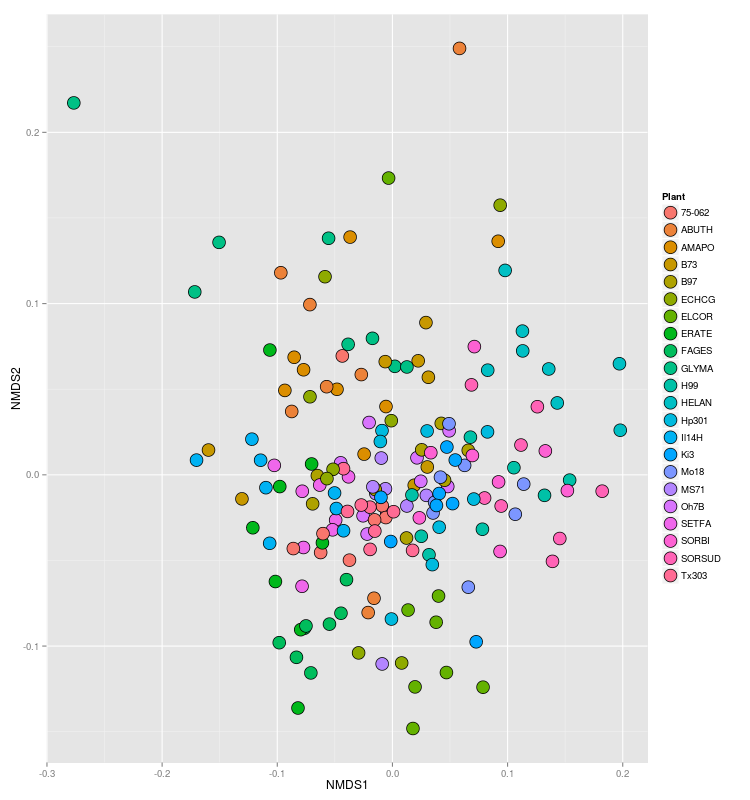

In [32]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

##Hypothesis Testing on Plant subset

In [50]:
%%R
df = as(sample_data(plant), "data.frame")
d = wunif.dist
plantadonis = adonis(d ~ DAP + Plant, df)
plantadonis


Call:
adonis(formula = d ~ DAP + Plant, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         1    0.4170 0.41697 29.7263 0.09559  0.001 ***
Plant      20    1.7851 0.08925  6.3629 0.40921  0.001 ***
Residuals 154    2.1602 0.01403         0.49520           
Total     175    4.3622                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [54]:
%%R
plant_group = get_variable(plant, "Plant")
d = wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5935 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0231 0.0308 0.0350 0.0404 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   2 4132.75 7935.5 11671.25 15400 14784
75-062   42  375.50 1026.0  3040.75  8062    28
ABUTH    66 2489.75 6486.5 12922.25 15128    28
AMAPO    16  938.50 2736.0  5022.25 13028    28
B73     107  876.00 3643.0  9604.00 12055    28
B97      34  903.25 1534.5  4489.75  8921    28
ECHCG    24 4880.00 8172.5 12648.25 14618    28
ELCOR    37  486.00 1685.5  3987.25 10575    28
ERATE    18  712.75 2074.5  5171.25 14206    28
FAGES     1   16.25   75.5   317.75  2169    28
GLYMA   497 4290.75 8761.0 11616.00 15076    28
H99      69 1149.50 2812.0  4430.50  6081    28
HELAN    78 1033.75 1727.0  2865.25  8425    28
Hp301  

## NMDS of unweighted-unifrac distances

In [33]:
%%R
registerDoParallel(cores=28)

uwunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1400851 
Run 1 stress 0.1456237 
Run 2 stress 0.1668139 
Run 3 stress 0.1554389 
Run 4 stress 0.1631645 
Run 5 stress 0.1562493 
Run 6 stress 0.1402482 
... procrustes: rmse 0.003617534  max resid 0.05179527 
Run 7 stress 0.1554036 
Run 8 stress 0.1520922 
Run 9 stress 0.1582269 
Run 10 stress 0.1644517 
Run 11 stress 0.140081 
... New best solution
... procrustes: rmse 0.000810312  max resid 0.006604266 
*** Solution reached


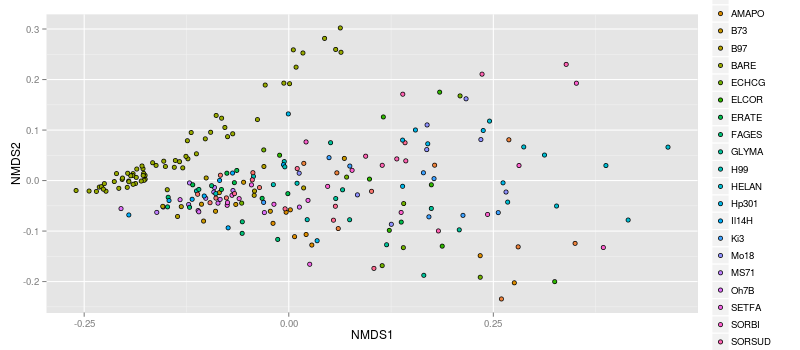

In [34]:
%%R -w 800 -h 350


nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = uwunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

#Heatmaps of taxon abundances



In [35]:
%%R
physeq.thresh %>% tax_table %>% head

Taxonomy Table:     [6 taxa by 8 taxonomic ranks]:
          Rank1      Rank2             Rank3          Rank4                   
OTU.5899  "Bacteria" "__Acidobacteria" "__32-21"      "__uncultured_bacterium"
OTU.11339 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.11867 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.12445 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.8680  "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.2666  "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
          Rank5                    Rank6 Rank7 Rank8
OTU.5899  NA                       NA    NA    NA   
OTU.11339 "__uncultured_bacterium" NA    NA    NA   
OTU.11867 "__uncultured_bacterium" NA    NA    NA   
OTU.12445 NA                       NA    NA    NA   
OTU.8680  NA                       NA    NA    NA   
OTU.2666  "__uncultured_bacterium" NA    NA    NA   


In [36]:
%%R -w 800 
physeq.thresh.t50 <- prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:10]), physeq.thresh)

plot_heatmap(physeq.thresh.t50, sample.label='Plant', taxa.label='Rank2')

ggsave("heatmap_rank2.pdf")

Saving 11.1 x 6.67 in image


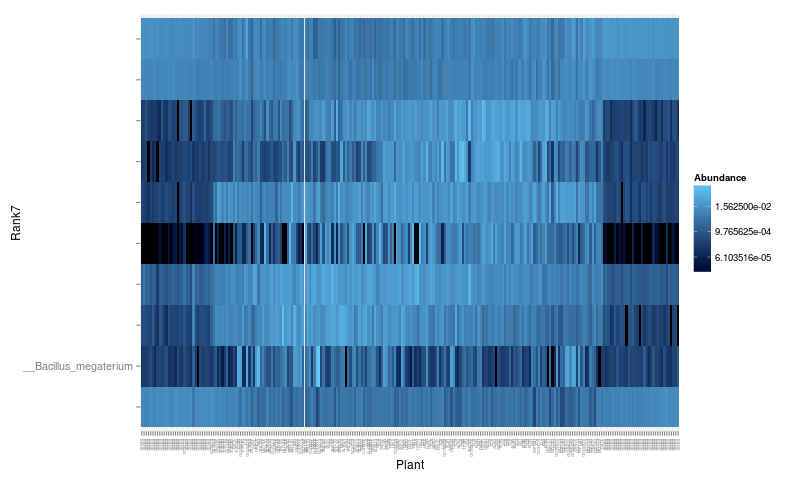

In [37]:
%%R -w 800 
physeq.thresh.t50 <- prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:10]), physeq.thresh)

plot_heatmap(physeq.thresh.t50, sample.label='Plant', taxa.label='Rank7')

##Analysis of changes in bare soil community over time

In [41]:
%%R
sample_names(physeq)

  [1] "sample2-1.06_Npos" "sample6-4.27_Npos" "sample4-4.27_Nneg"
  [4] "sample4-1.06_Nneg" "sample2-1.06_Nneg" "sample6-3.07_Nneg"
  [7] "sample5-3.07_Nneg" "sample6-3.07_Npos" "sample3-3.07_Npos"
 [10] "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample1-4.27_Npos"
 [13] "sample4-1.03_Npos" "sample5-2.06_Npos" "sample5-4.08_Npos"
 [16] "sample4-3.07_Nneg" "sample5-4.28_Npos" "sample6-1.06_Npos"
 [19] "sample4-2.05_Nneg" "sample2-4.27_Nneg" "sample1-2.05_Nneg"
 [22] "sample5-1.29_Npos" "sample5-4.27_Npos" "sample5-4.27_Nneg"
 [25] "sample1-3.07_Nneg" "sample4-2.02_Nneg" "sample4-4.21_Nneg"
 [28] "sample2-2.05_Nneg" "sample6-2.13_Npos" "sample5-2.29_Nneg"
 [31] "sample5-2.06_Nneg" "sample1-2.23_Nneg" "sample6-2.26_Nneg"
 [34] "sample6-3.18_Nneg" "sample5-3.13_Nneg" "sample2-2.08_Nneg"
 [37] "sample1-2.05_Npos" "sample3-2.05_Nneg" "sample5-1.17_Nneg"
 [40] "sample6-3.01_Npos" "sample3-2.03_Nneg" "sample5-4.08_Nneg"
 [43] "sample5-4.05_Npos" "sample5-1.06_Npos" "sample1-4.27_Nneg"
 [46] "sam